# Real-Time Emotion Detection

Live emotion recognition using webcam feed with pre-trained ResNet-18 model.

**Author:** FC211033 Sahan  
**Date:** July 2025

## 1. Import Dependencies

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, models

import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import time
import os
from IPython.display import display, clear_output
import warnings
warnings.filterwarnings('ignore')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")
print(f"OpenCV version: {cv2.__version__}")

Device: cuda
OpenCV version: 4.12.0


## 2. Configuration

In [2]:
CONFIG = {
    'model_path': './models/best_resnet_model.pth',
    'cascade_path': './haarcascade_frontalface_default.xml',
    'image_size': 64,
    'emotions': ['angry', 'happy', 'neutral', 'sad', 'surprise'],
    'num_classes': 5,
    'confidence_threshold': 0.5,
    'frame_skip': 2,  # Process every nth frame for performance
    'display_size': (800, 600)
}

# Color scheme for emotions
EMOTION_COLORS = {
    'angry': (0, 0, 255),      # Red
    'happy': (0, 255, 0),      # Green
    'neutral': (255, 255, 0),  # Cyan
    'sad': (255, 0, 0),        # Blue
    'surprise': (255, 0, 255)  # Magenta
}

print("Real-time Detection Configuration:")
print("-" * 40)
for key, value in CONFIG.items():
    if key != 'display_size':
        print(f"{key:20}: {value}")
print(f"{'display_size':20}: {CONFIG['display_size'][0]}x{CONFIG['display_size'][1]}")

Real-time Detection Configuration:
----------------------------------------
model_path          : ./models/best_resnet_model.pth
cascade_path        : ./haarcascade_frontalface_default.xml
image_size          : 64
emotions            : ['angry', 'happy', 'neutral', 'sad', 'surprise']
num_classes         : 5
confidence_threshold: 0.5
frame_skip          : 2
display_size        : 800x600


## 3. Model Architecture and Loading

In [3]:
class EmotionResNet(nn.Module):
    def __init__(self, num_classes=5, dropout_rate=0.3):
        super(EmotionResNet, self).__init__()
        
        self.backbone = models.resnet18(pretrained=False)
        feature_size = self.backbone.fc.in_features
        
        self.backbone.fc = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(feature_size, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(dropout_rate),
            nn.Linear(256, num_classes)
        )
    
    def forward(self, x):
        return self.backbone(x)

def load_model(model_path):
    model = EmotionResNet(CONFIG['num_classes']).to(device)
    
    if os.path.exists(model_path):
        checkpoint = torch.load(model_path, map_location=device)
        model.load_state_dict(checkpoint['model_state_dict'])
        model.eval()
        
        val_acc = checkpoint.get('val_acc', 'Unknown')
        epoch = checkpoint.get('epoch', 'Unknown')
        
        print(f"Model loaded successfully")
        print(f"Training epoch: {epoch}")
        print(f"Validation accuracy: {val_acc:.2f}%")
        
        return model
    else:
        raise FileNotFoundError(f"Model not found at {model_path}")

# Load pre-trained model
model = load_model(CONFIG['model_path'])

# Define preprocessing transform
transform = transforms.Compose([
    transforms.Resize((CONFIG['image_size'], CONFIG['image_size'])),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

print(f"\nModel ready for real-time inference")
print(f"Input size: {CONFIG['image_size']}x{CONFIG['image_size']}")
print(f"Emotions: {', '.join(CONFIG['emotions'])}")

Model loaded successfully
Training epoch: 25
Validation accuracy: 63.99%

Model ready for real-time inference
Input size: 64x64
Emotions: angry, happy, neutral, sad, surprise


## 4. Face Detection Setup

In [4]:
def load_face_detector(cascade_path):
    if os.path.exists(cascade_path):
        face_cascade = cv2.CascadeClassifier(cascade_path)
        print(f"Face detector loaded from: {cascade_path}")
        return face_cascade
    else:
        print(f"Cascade file not found at {cascade_path}")
        print("Trying to load default OpenCV cascade...")
        face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
        if face_cascade.empty():
            raise FileNotFoundError("Could not load face detector")
        print("Default face detector loaded successfully")
        return face_cascade

face_cascade = load_face_detector(CONFIG['cascade_path'])

def detect_faces(frame, face_cascade):
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(
        gray,
        scaleFactor=1.1,
        minNeighbors=5,
        minSize=(50, 50),
        flags=cv2.CASCADE_SCALE_IMAGE
    )
    return faces, gray

print("Face detection ready")

Face detector loaded from: ./haarcascade_frontalface_default.xml
Face detection ready


## 5. Emotion Prediction Functions

In [5]:
def predict_emotion(face_img, model, transform):
    try:
        # Resize face to model input size
        face_resized = cv2.resize(face_img, (CONFIG['image_size'], CONFIG['image_size']))
        
        # Convert to PIL Image and then to RGB
        pil_image = Image.fromarray(face_resized).convert('RGB')
        
        # Apply transforms
        input_tensor = transform(pil_image).unsqueeze(0).to(device)
        
        # Predict
        with torch.no_grad():
            outputs = model(input_tensor)
            probabilities = F.softmax(outputs, dim=1)
            confidence, predicted = torch.max(probabilities, 1)
            
            emotion_idx = predicted.item()
            emotion = CONFIG['emotions'][emotion_idx]
            confidence_score = confidence.item()
            
            # Get all probabilities
            all_probs = probabilities.squeeze().cpu().numpy()
            
            return emotion, confidence_score, all_probs
    except Exception as e:
        print(f"Error in emotion prediction: {e}")
        return "unknown", 0.0, np.zeros(len(CONFIG['emotions']))

def draw_emotion_info(frame, x, y, w, h, emotion, confidence, all_probs):
    # Draw face rectangle
    color = EMOTION_COLORS.get(emotion, (255, 255, 255))
    thickness = 3 if confidence > CONFIG['confidence_threshold'] else 2
    cv2.rectangle(frame, (x, y), (x + w, y + h), color, thickness)
    
    # Draw emotion label
    label = f"{emotion.upper()}: {confidence:.2f}"
    label_size = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.8, 2)[0]
    
    # Background for text
    cv2.rectangle(frame, (x, y - 35), (x + label_size[0] + 10, y), color, -1)
    cv2.putText(frame, label, (x + 5, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 255, 255), 2)
    
    # Draw emotion probabilities bar
    bar_x = x + w + 10
    bar_y = y
    bar_width = 150
    bar_height = 20
    
    for i, (emotion_name, prob) in enumerate(zip(CONFIG['emotions'], all_probs)):
        bar_y_pos = bar_y + i * (bar_height + 5)
        
        # Background bar
        cv2.rectangle(frame, (bar_x, bar_y_pos), (bar_x + bar_width, bar_y_pos + bar_height), (50, 50, 50), -1)
        
        # Probability bar
        prob_width = int(bar_width * prob)
        emotion_color = EMOTION_COLORS.get(emotion_name, (255, 255, 255))
        cv2.rectangle(frame, (bar_x, bar_y_pos), (bar_x + prob_width, bar_y_pos + bar_height), emotion_color, -1)
        
        # Text label
        text = f"{emotion_name}: {prob:.2f}"
        cv2.putText(frame, text, (bar_x + bar_width + 10, bar_y_pos + 15), 
                   cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)
    
    return frame

print("Emotion prediction functions ready")

Emotion prediction functions ready


## 6. Real-Time Detection

In [6]:
def start_realtime_detection():
    # Initialize webcam
    cap = cv2.VideoCapture(0)
    
    if not cap.isOpened():
        print("Error: Could not open webcam")
        return
    
    # Set camera properties
    cap.set(cv2.CAP_PROP_FRAME_WIDTH, CONFIG['display_size'][0])
    cap.set(cv2.CAP_PROP_FRAME_HEIGHT, CONFIG['display_size'][1])
    cap.set(cv2.CAP_PROP_FPS, 30)
    
    print("Real-time emotion detection started")
    print("Press 'q' to quit, 's' to save screenshot")
    print("-" * 50)
    
    frame_count = 0
    fps_counter = 0
    fps_time = time.time()
    
    try:
        while True:
            ret, frame = cap.read()
            if not ret:
                print("Error: Could not read frame")
                break
            
            frame_count += 1
            
            # Flip frame horizontally for mirror effect
            frame = cv2.flip(frame, 1)
            
            # Process every nth frame for performance
            if frame_count % CONFIG['frame_skip'] == 0:
                # Detect faces
                faces, gray = detect_faces(frame, face_cascade)
                
                # Process each detected face
                for (x, y, w, h) in faces:
                    # Extract face region
                    face_gray = gray[y:y+h, x:x+w]
                    
                    # Predict emotion
                    emotion, confidence, all_probs = predict_emotion(face_gray, model, transform)
                    
                    # Draw emotion information
                    frame = draw_emotion_info(frame, x, y, w, h, emotion, confidence, all_probs)
            
            # Calculate and display FPS
            fps_counter += 1
            if time.time() - fps_time > 1.0:
                fps = fps_counter / (time.time() - fps_time)
                fps_counter = 0
                fps_time = time.time()
                
                # Display FPS and instructions
                cv2.putText(frame, f"FPS: {fps:.1f}", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
            
            # Add instructions
            cv2.putText(frame, "Press 'q' to quit, 's' to save", (10, frame.shape[0] - 20), 
                       cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)
            
            # Display frame
            cv2.imshow('Real-Time Emotion Detection', frame)
            
            # Handle key presses
            key = cv2.waitKey(1) & 0xFF
            if key == ord('q'):
                print("Quitting...")
                break
            elif key == ord('s'):
                timestamp = time.strftime("%Y%m%d_%H%M%S")
                filename = f"emotion_detection_{timestamp}.jpg"
                cv2.imwrite(filename, frame)
                print(f"Screenshot saved as {filename}")
    
    except KeyboardInterrupt:
        print("\nInterrupted by user")
    
    finally:
        # Clean up
        cap.release()
        cv2.destroyAllWindows()
        print("Webcam released and windows closed")

print("Real-time detection function ready")
print("\nRun the next cell to start emotion detection!")

Real-time detection function ready

Run the next cell to start emotion detection!


## 7. Start Detection

In [7]:
# Start real-time emotion detection
start_realtime_detection()

Real-time emotion detection started
Press 'q' to quit, 's' to save screenshot
--------------------------------------------------
Quitting...
Quitting...
Webcam released and windows closed
Webcam released and windows closed


## 8. Test with Static Image

In [10]:
def test_static_image(image_path=None):
    if image_path is None:
        # Capture a single frame from webcam for testing
        cap = cv2.VideoCapture(0)
        if not cap.isOpened():
            print("Error: Could not open webcam")
            return
        
        ret, frame = cap.read()
        cap.release()
        
        if not ret:
            print("Error: Could not capture frame")
            return
    else:
        frame = cv2.imread(image_path)
        if frame is None:
            print(f"Error: Could not load image from {image_path}")
            return
    
    # Process the frame
    faces, gray = detect_faces(frame, face_cascade)
    
    print(f"Detected {len(faces)} face(s)")
    
    # Process each face
    for i, (x, y, w, h) in enumerate(faces):
        face_gray = gray[y:y+h, x:x+w]
        emotion, confidence, all_probs = predict_emotion(face_gray, model, transform)
        
        print(f"\nFace {i+1}:")
        print(f"  Predicted emotion: {emotion}")
        print(f"  Confidence: {confidence:.3f}")
        print(f"  All probabilities:")
        for j, (emo, prob) in enumerate(zip(CONFIG['emotions'], all_probs)):
            print(f"    {emo:8}: {prob:.3f}")
        
        frame = draw_emotion_info(frame, x, y, w, h, emotion, confidence, all_probs)
    
    # Convert BGR to RGB for matplotlib
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    
    # Display result
    plt.figure(figsize=(12, 8))
    plt.imshow(frame_rgb)
    plt.axis('off')
    plt.title('Emotion Detection Test', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

print("Static image test function ready")
print("Run: test_static_image() to test with webcam capture")
print("Run: test_static_image('path/to/image.jpg') to test with specific image")

Static image test function ready
Run: test_static_image() to test with webcam capture
Run: test_static_image('path/to/image.jpg') to test with specific image


## 9. Performance Monitor

In [9]:
def benchmark_model():
    print("Benchmarking model performance...")
    
    # Create dummy input
    dummy_input = torch.randn(1, 3, CONFIG['image_size'], CONFIG['image_size']).to(device)
    
    # Warm up
    for _ in range(10):
        with torch.no_grad():
            _ = model(dummy_input)
    
    # Benchmark inference time
    num_runs = 100
    start_time = time.time()
    
    for _ in range(num_runs):
        with torch.no_grad():
            _ = model(dummy_input)
    
    end_time = time.time()
    avg_time = (end_time - start_time) / num_runs
    fps = 1 / avg_time
    
    print(f"\nBenchmark Results:")
    print(f"  Average inference time: {avg_time*1000:.2f} ms")
    print(f"  Theoretical max FPS: {fps:.1f}")
    print(f"  Device: {device}")
    print(f"  Model size: {CONFIG['image_size']}x{CONFIG['image_size']}")
    
    # Memory usage (if CUDA)
    if device.type == 'cuda':
        memory_allocated = torch.cuda.memory_allocated(device) / 1024**2
        memory_cached = torch.cuda.memory_reserved(device) / 1024**2
        print(f"  GPU Memory allocated: {memory_allocated:.1f} MB")
        print(f"  GPU Memory cached: {memory_cached:.1f} MB")

benchmark_model()

Benchmarking model performance...

Benchmark Results:
  Average inference time: 4.52 ms
  Theoretical max FPS: 221.2
  Device: cuda
  Model size: 64x64
  GPU Memory allocated: 51.4 MB
  GPU Memory cached: 172.0 MB

Benchmark Results:
  Average inference time: 4.52 ms
  Theoretical max FPS: 221.2
  Device: cuda
  Model size: 64x64
  GPU Memory allocated: 51.4 MB
  GPU Memory cached: 172.0 MB


Detected 1 face(s)

Face 1:
  Predicted emotion: neutral
  Confidence: 0.526
  All probabilities:
    angry   : 0.049
    happy   : 0.296
    neutral : 0.526
    sad     : 0.110
    surprise: 0.019


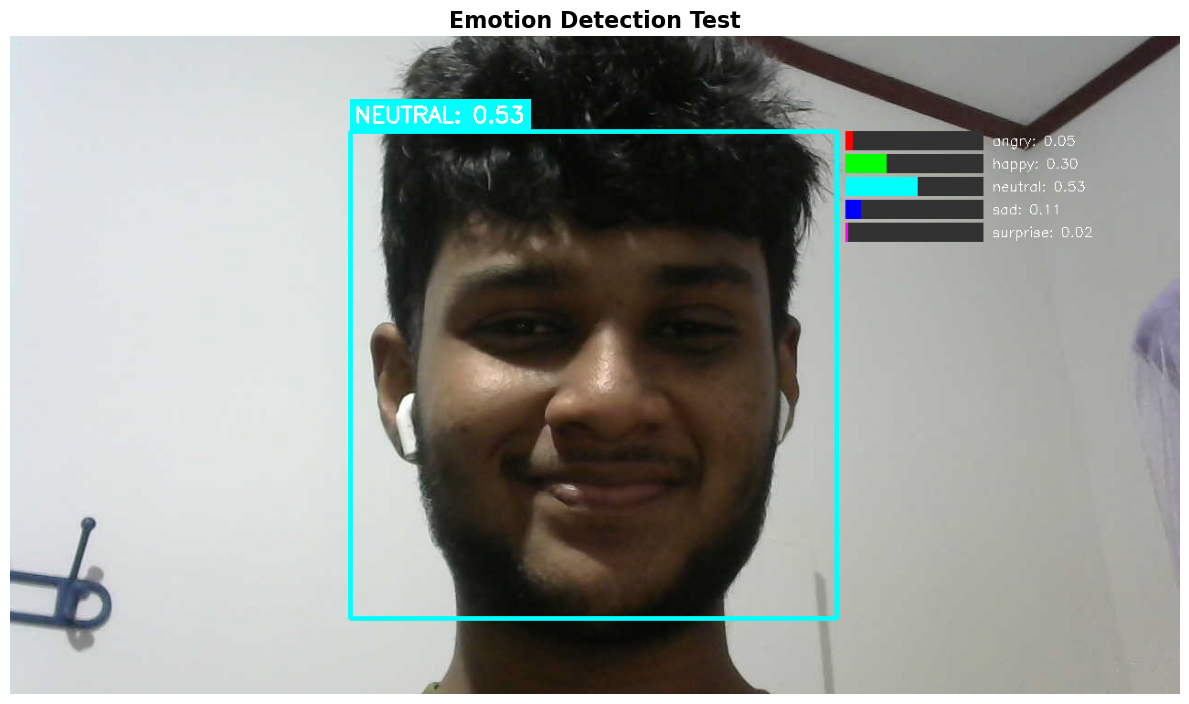

In [17]:
# Checking locally captured images of mine
test_static_image('WIN_20250715_03_57_38_Pro.jpg')

## 10. Instructions and Tips

### Usage Instructions:

1. **Start Detection**: Run cell 7 to begin real-time emotion detection
2. **Controls**:
   - Press `q` to quit the detection
   - Press `s` to save a screenshot with timestamp
3. **Test Mode**: Use cell 8 to test with static images or single webcam captures

### Features:

- **Real-time Processing**: Live webcam feed with emotion recognition
- **Multiple Face Detection**: Handles multiple faces simultaneously
- **Confidence Visualization**: Color-coded rectangles and probability bars

### Emotion Colors:

- **Angry**: Red
- **Happy**: Green  
- **Neutral**: Cyan
- **Sad**: Blue
- **Surprise**: Magenta

### Tips for Better Results:

- Ensure good lighting conditions
- Face the camera directly
- Maintain reasonable distance 
- Avoid extreme facial angles
- Clear facial expressions work best